In [ ]:
"""
En este modelo se entrena con los cuatro dataset restantes de UCY/ETH en marco mundo,
agregandole el flujo optico
"""

In [1]:
import sys
#sys.path.append('/home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes')
sys.path.append('../keypoints/partes')
import numpy as np
#from process_file import process_file_modif
#from process_file import process_file_modif_varios
from process_file import datos_subprocesados_varios
import batches_data
import model

import tensorflow as tf 
tf.reset_default_graph()

import entrenamientoevaluacion
from entrenamientoevaluacion import evaluate
from interaccion_no_normalizada import batch_vecinos

In [2]:
class parameters:
    def __init__(self):
        self.obs_len = 8
        self.pred_len = 12
        self.add_social = False
        self.kp_num = 18
        self.add_kp = False
        #self.directory_flujo='/home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints'
        self.directory_flujo='../keypoints'

In [3]:
# Cargamos los argumentos
arguments = parameters()

# List of data directories where raw data resides
datasets_entrena_vali = [0,1,2,3]
datasets_prueba = [4]

data_entrena_vali = datos_subprocesados_varios(datasets_entrena_vali, arguments, ',')
data_prueba = datos_subprocesados_varios(datasets_prueba, arguments, ',')
#data_ucyuniv = process_file_modif_varios(ucyuniv_pix_path, arguments, ',')

../data1/eth/univ/mundo/mun_pos.csv
339
../data1/eth/hotel/mundo/mun_pos.csv
913
../data1/ucy/zara/zara01/mundo/mun_pos.csv
2356
../data1/ucy/zara/zara02/mundo/mun_pos.csv
5910
(9518, 8, 64)
../data1/ucy/univ/mundo/mun_pos.csv
10039
(10039, 8, 64)


# Dividimos los datos

In [4]:
#se fija la semilaa
import random
random.seed(0)

# Muestreamos aleatoriamente para separar datos de entrenamiento, validacion y prueba
prob = 0.92
# La cantidad total de listas de tam 8 
ndata = len(data_entrena_vali[list(data_entrena_vali.keys())[2]])
idx = random.sample(range(ndata), ndata)
long1 = int(ndata*prob)
long2 = int(ndata-long1)


idx_train = idx[0:long1]
idx_val = idx[long1:]


# conjunto de entrenamiento
data1 = {
     "obs_traj": data_entrena_vali["obs_traj"][idx_train],
     "obs_traj_rel": data_entrena_vali["obs_traj_rel"][idx_train],
    
     "pred_traj": data_entrena_vali["pred_traj"][idx_train],
     "pred_traj_rel": data_entrena_vali["pred_traj_rel"][idx_train],
    
     "key_idx": data_entrena_vali["key_idx"][[idx_train]],
     "obs_flujo" : data_entrena_vali["obs_flujo"][idx_train],
     #"pred_kp": data_pets["pred_kp"][idx_train],
     #"obs_person": data_pets["obs_person"][idx_train],
}


# conjunto de validacion
data3 ={
     "obs_traj": data_entrena_vali["obs_traj"][idx_val],
     "obs_traj_rel": data_entrena_vali["obs_traj_rel"][idx_val],
     "pred_traj": data_entrena_vali["pred_traj"][idx_val],
     "pred_traj_rel": data_entrena_vali["pred_traj_rel"][idx_val],
     "key_idx": data_entrena_vali["key_idx"][[idx_val]],
     "obs_flujo" : data_entrena_vali["obs_flujo"][idx_val],
}


#if arguments.add_kp:
#  print(data3['obs_person_rel'])

print("data_train: "+ str(len(data1[list(data1.keys())[0]])))
print("data_test: "+ str(len(data_prueba[list(data_prueba .keys())[0]])))
print("data_val: "+ str(len(data3[list(data3.keys())[0]])))
#print("data4: "+ str(len(data4[list(data4.keys())[0]])))


data_train: 8756
data_test: 10039
data_val: 762


/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


# Guardamos los datos divididos

In [5]:
import pickle

#conjunto de entrenamiento
pickle_out = open("data1_UCYUNIV_12.pickle","wb")
pickle.dump(data1, pickle_out, protocol=2)
pickle_out.close()

#conjunto de prueba
pickle_out = open("data2_UCYUNIV_12.pickle","wb")
pickle.dump(data_prueba, pickle_out, protocol=2)
pickle_out.close()

#conjunto de validacion
pickle_out = open("data3_UCYUNIV_12.pickle","wb")
pickle.dump(data3, pickle_out, protocol=2)
pickle_out.close()

# Parametros para el modelo 

In [6]:
class parameters1:
    def __init__(self, add_kp = None, add_social=None, train_num_examples=None):
        # -----------------
        # Similar a como se procesaron los datos
        self.obs_len = 8
        self.pred_len = 12
        if add_kp is None:
            print('Parameter add kpp missing')
            return
        if train_num_examples is None:
            print('El parametro train_examples fue olvidado')
            return
        if add_social is None:
            print('Parameter add social missing')
            return
        
        self.add_kp = add_kp
        self.train_num_examples = train_num_examples
        self.add_social = add_social
        
        self.kp_num = 18
        self.kp_size = 18
        #self.maxNumPed = 8
        #self.grid_size = 4
        #self.neighborhood_size = 32
        #self.dimensions = [768,576]
        #self.limites=[-15.88,11.56,-19.09,5.99]
        #self.bound=[0.7,0.5]
        # ------------------
        self.num_epochs = 100
        self.batch_size = 20 # batch size
        self.validate = 300
        self.P = 2 # dimensión
        self.enc_hidden_size = 128 # el nombre lo dice
        self.dec_hidden_size = 128
        self.emb_size = 64
        self.keep_prob = 0.7 # dropout
        
        self.min_ped = 1
        self.seq_len = self.obs_len + self.pred_len
        self.reverse_xy = False
        
        self.activation_func = tf.nn.tanh
        self.activation_func1 = tf.nn.relu
        self.is_train = True
        self.is_test = False
        self.multi_decoder = False
        self.modelname = 'gphuctl'
        
        self.init_lr = 0.002 # 0.01
        self.learning_rate_decay = 0.85
        self.num_epoch_per_decay = 2.0
        self.optimizer = 'adam'
        self.emb_lr = 1.0
        #self.clip_gradient_norm = 10.0
        #Para cuando entreno y quiero guardar el mejor modelo
        self.load_best = True

# Se entrena el modelo

In [7]:
import os 
from tqdm import tqdm
import tensorflow as tf
import math

tf.reset_default_graph()

arguments = parameters1(add_kp = False, add_social = True,train_num_examples=len(data1['obs_traj']))
model = model.Model(arguments)

train_data = batches_data.Dataset(data1,arguments)
val_data = batches_data.Dataset(data3,arguments)

saver = tf.train.Saver(max_to_keep = 2)
bestsaver = tf.train.Saver(max_to_keep = 2)


trainer = entrenamientoevaluacion.Trainer(model,arguments)
tester = entrenamientoevaluacion.Tester(model, arguments)

#inicializamos las variables globales
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

increment_global_step_op = tf.assign(model.global_step, model.global_step+1)

val_perf = []
loss = -1
metric = 'ade'

best = {metric:999999, 'fde':0, 'step':-1}
is_start = True

num_steps = int(math.ceil(train_data.num_examples/float(arguments.batch_size)))
loss_list = []
print(num_steps)

for i in range(arguments.num_epochs):
    print('Epoca {0}.' .format(i+1), 'lr:', sess.run(trainer.get_lr()))
    
    #For de batches
    for idx, batch in tqdm(train_data.get_batches(arguments.batch_size,num_steps = num_steps),total=num_steps):
        
        sess.run(increment_global_step_op)
        global_step = sess.run(model.global_step)

        #Evaluamos el entrenamiento
        if((global_step%arguments.validate==0) or (arguments.load_best and is_start)):
            tqdm.write("\tsaving model %s..." % global_step)
            checkpoint_path_model = os.path.join('SINKP_NON_UCYUNIV_12', 'model.ckpt')
            saver.save(sess,checkpoint_path_model , global_step = global_step)
            tqdm.write("\tdone")
            
            print('Evaluating')
            results = evaluate(val_data, tester,sess,arguments)
            print(results)
           
            tqdm.write(("\t last loss:%.9f, eval on validation:%s,"
                    " (best %s:%s at step %s) ") % (loss,["%s: %s" % (k, results[k]) for k in sorted(results.keys())], metric,best[metric], best["step"]))
            if results["ade"]< best[metric]:
                best[metric] = results["ade"]
                best["fde"] =results["fde"]
                best["step"] = global_step
                
                tqdm.write("\t saving best model...")
                checkpoint_path_model_best = os.path.join('SINKP_NON_UCYUNIV-BEST_12', 'model_best.ckpt')
                bestsaver.save(sess,checkpoint_path_model_best,global_step = global_step)
                tqdm.write("\t done.")
                finalperf = results
                val_perf.append((loss, results))
            is_start = False
        loss, train_op = trainer.step(sess, batch)
        loss_list.append(loss)
    
if((global_step % arguments.validate)!=0):
  checkpoint_path_model = os.path.join('SINKP_NON_UCYUNIV_12', 'model.ckpt')
  saver.save(sess,checkpoint_path_model , global_step = global_step)

print("best eval on val %s: %s at %s step y fde es %s " % (metric, best[metric], best["step"],best["fde"]))


W0105 14:18:34.815006 139949982123776 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:13: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0105 14:18:34.846173 139949982123776 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:31: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0105 14:18:34.860140 139949982123776 deprecation.py:323] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:70: __init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0105 14:18:34.861871 139949982123776 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:72: The name tf.nn.rnn_cell.DropoutW

438
('Epoca 1.', 'lr:', 0.002)
	saving model 1...



  0%|          | 0/39 [00:00<?, ?it/s]

	done
Evaluating



100%|##########| 39/39 [00:01<00:00, 36.92it/s]

{'ade': 1.7483271, 'fde': 3.207749}
	 last loss:-1.000000000, eval on validation:['ade: 1.7483271', 'fde: 3.207749'], (best ade:999999 at step -1) 
	 saving best model...
	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 300...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 63.50it/s]

{'ade': 0.4229086, 'fde': 0.90034777}
	 last loss:0.000531877, eval on validation:['ade: 0.4229086', 'fde: 0.90034777'], (best ade:1.7483271 at step 1) 
	 saving best model...
	 done.


  1%|          | 3/438 [00:00<00:17, 24.61it/s]

('Epoca 2.', 'lr:', 0.002)


 36%|███▋      | 159/438 [00:06<00:10, 25.39it/s]W0105 14:19:06.094558 139949982123776 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.

  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 600...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 82.53it/s]

{'ade': 0.39866722, 'fde': 0.86969876}
	 last loss:0.000658834, eval on validation:['ade: 0.39866722', 'fde: 0.86969876'], (best ade:0.4229086 at step 300) 
	 saving best model...
	 done.


  1%|          | 3/438 [00:00<00:18, 23.25it/s]

('Epoca 3.', 'lr:', 0.0017000001)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 900...
	done
Evaluating



  6%|▌         | 27/438 [00:01<00:36, 11.37it/s][A

{'ade': 0.4240398, 'fde': 0.931696}
	 last loss:0.000650425, eval on validation:['ade: 0.4240398', 'fde: 0.931696'], (best ade:0.39866722 at step 600) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 1200...
	done
Evaluating



 75%|███████▍  | 327/438 [00:14<00:09, 11.66it/s]A

{'ade': 0.39888334, 'fde': 0.86430556}
	 last loss:0.000394544, eval on validation:['ade: 0.39888334', 'fde: 0.86430556'], (best ade:0.39866722 at step 600) 


  0%|          | 2/438 [00:00<00:26, 16.19it/s]

('Epoca 4.', 'lr:', 0.0017000001)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 1500...
	done
Evaluating



 43%|████▎     | 188/438 [00:07<00:25,  9.69it/s]A

{'ade': 0.40010536, 'fde': 0.8585095}
	 last loss:0.000557838, eval on validation:['ade: 0.40010536', 'fde: 0.8585095'], (best ade:0.39866722 at step 600) 


  0%|          | 1/438 [00:00<00:45,  9.64it/s]

('Epoca 5.', 'lr:', 0.0014450002)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 1800...
	done
Evaluating



 11%|█         | 49/438 [00:02<00:41,  9.42it/s][A

{'ade': 0.41573077, 'fde': 0.91903967}
	 last loss:0.000277534, eval on validation:['ade: 0.41573077', 'fde: 0.91903967'], (best ade:0.39866722 at step 600) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 2100...
	done
Evaluating



 80%|████████  | 352/438 [00:15<00:07, 11.94it/s]A

{'ade': 0.42649883, 'fde': 0.9426731}
	 last loss:0.000610734, eval on validation:['ade: 0.42649883', 'fde: 0.9426731'], (best ade:0.39866722 at step 600) 


  1%|          | 3/438 [00:00<00:17, 25.05it/s]

('Epoca 6.', 'lr:', 0.0014450002)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 2400...
	done
Evaluating



 48%|████▊     | 212/438 [00:08<00:19, 11.54it/s]A

{'ade': 0.4346289, 'fde': 0.95856243}
	 last loss:0.001059833, eval on validation:['ade: 0.4346289', 'fde: 0.95856243'], (best ade:0.39866722 at step 600) 


  0%|          | 2/438 [00:00<00:30, 14.46it/s]

('Epoca 7.', 'lr:', 0.0012282502)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 2700...
	done
Evaluating



 17%|█▋        | 74/438 [00:03<00:38,  9.42it/s][A

{'ade': 0.40547898, 'fde': 0.8825017}
	 last loss:0.000468399, eval on validation:['ade: 0.40547898', 'fde: 0.8825017'], (best ade:0.39866722 at step 600) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 3000...
	done
Evaluating



 85%|████████▌ | 374/438 [00:15<00:06,  9.33it/s]A

{'ade': 0.41242573, 'fde': 0.90623975}
	 last loss:0.000605238, eval on validation:['ade: 0.41242573', 'fde: 0.90623975'], (best ade:0.39866722 at step 600) 


  0%|          | 1/438 [00:00<00:53,  8.17it/s]

('Epoca 8.', 'lr:', 0.0012282502)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 3300...
	done
Evaluating



 54%|█████▍    | 236/438 [00:10<00:21,  9.57it/s]A

{'ade': 0.41365084, 'fde': 0.91822773}
	 last loss:0.000503117, eval on validation:['ade: 0.41365084', 'fde: 0.91822773'], (best ade:0.39866722 at step 600) 


  1%|          | 3/438 [00:00<00:17, 24.66it/s]

('Epoca 9.', 'lr:', 0.0010440127)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 3600...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 88.17it/s]

{'ade': 0.39178807, 'fde': 0.85612684}
	 last loss:0.000296788, eval on validation:['ade: 0.39178807', 'fde: 0.85612684'], (best ade:0.39866722 at step 600) 
	 saving best model...
	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 3900...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 80.48it/s]

{'ade': 0.38165134, 'fde': 0.8348927}
	 last loss:0.000417571, eval on validation:['ade: 0.38165134', 'fde: 0.8348927'], (best ade:0.39178807 at step 3600) 
	 saving best model...


 91%|█████████ | 399/438 [00:17<00:04,  9.48it/s]

	 done.


  0%|          | 2/438 [00:00<00:30, 14.14it/s]

('Epoca 10.', 'lr:', 0.0010440127)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 4200...
	done
Evaluating



 59%|█████▉    | 260/438 [00:11<00:18,  9.88it/s]A

{'ade': 0.40738082, 'fde': 0.91054267}
	 last loss:0.000483154, eval on validation:['ade: 0.40738082', 'fde: 0.91054267'], (best ade:0.38165134 at step 3900) 


  1%|          | 3/438 [00:00<00:18, 23.43it/s]

('Epoca 11.', 'lr:', 0.0008874108)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 4500...
	done
Evaluating



 28%|██▊       | 123/438 [00:05<00:27, 11.32it/s]A

{'ade': 0.39479372, 'fde': 0.8511791}
	 last loss:0.000367705, eval on validation:['ade: 0.39479372', 'fde: 0.8511791'], (best ade:0.38165134 at step 3900) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 4800...
	done
Evaluating



 97%|█████████▋| 423/438 [00:18<00:01, 11.56it/s]A

{'ade': 0.39322716, 'fde': 0.8609403}
	 last loss:0.000635927, eval on validation:['ade: 0.39322716', 'fde: 0.8609403'], (best ade:0.38165134 at step 3900) 


  0%|          | 1/438 [00:00<00:49,  8.81it/s]

('Epoca 12.', 'lr:', 0.0008874108)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 5100...
	done
Evaluating



 65%|██████▍   | 283/438 [00:12<00:16,  9.16it/s]A

{'ade': 0.39410454, 'fde': 0.8644193}
	 last loss:0.000368050, eval on validation:['ade: 0.39410454', 'fde: 0.8644193'], (best ade:0.38165134 at step 3900) 


  0%|          | 1/438 [00:00<00:47,  9.25it/s]

('Epoca 13.', 'lr:', 0.0007542992)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 5400...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 83.61it/s]

{'ade': 0.36792862, 'fde': 0.7914231}
	 last loss:0.000231522, eval on validation:['ade: 0.36792862', 'fde: 0.7914231'], (best ade:0.38165134 at step 3900) 
	 saving best model...


 33%|███▎      | 145/438 [00:06<00:36,  7.97it/s]

	 done.


  0%|          | 2/438 [00:00<00:25, 16.80it/s]

('Epoca 14.', 'lr:', 0.0007542992)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 5700...
	done
Evaluating



  2%|▏         | 10/438 [00:01<00:51,  8.29it/s][A

{'ade': 0.39631268, 'fde': 0.85692495}
	 last loss:0.000405029, eval on validation:['ade: 0.39631268', 'fde: 0.85692495'], (best ade:0.36792862 at step 5400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 6000...
	done
Evaluating



 71%|███████   | 310/438 [00:13<00:11, 11.56it/s]A

{'ade': 0.4997999, 'fde': 1.1591393}
	 last loss:0.000597706, eval on validation:['ade: 0.4997999', 'fde: 1.1591393'], (best ade:0.36792862 at step 5400) 


  0%|          | 2/438 [00:00<00:28, 15.33it/s]

('Epoca 15.', 'lr:', 0.0006411543)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 6300...
	done
Evaluating



 39%|███▉      | 170/438 [00:07<00:30,  8.76it/s]A

{'ade': 0.39027727, 'fde': 0.8630955}
	 last loss:0.000530591, eval on validation:['ade: 0.39027727', 'fde: 0.8630955'], (best ade:0.36792862 at step 5400) 


  1%|          | 3/438 [00:00<00:18, 23.11it/s]

('Epoca 16.', 'lr:', 0.0006411543)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 6600...
	done
Evaluating



  8%|▊         | 33/438 [00:02<00:35, 11.36it/s][A

{'ade': 0.3688569, 'fde': 0.8069639}
	 last loss:0.000401558, eval on validation:['ade: 0.3688569', 'fde: 0.8069639'], (best ade:0.36792862 at step 5400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 6900...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 74.49it/s]

{'ade': 0.36655417, 'fde': 0.79121894}
	 last loss:0.000359291, eval on validation:['ade: 0.36655417', 'fde: 0.79121894'], (best ade:0.36792862 at step 5400) 
	 saving best model...


  0%|          | 2/438 [00:00<00:24, 17.51it/s]

	 done.
('Epoca 17.', 'lr:', 0.0005449812)


 44%|████▎     | 191/438 [00:09<00:13, 18.47it/s]

	saving model 7200...



 21%|##        | 8/39 [00:00<00:00, 70.06it/s]

	done
Evaluating



 44%|████▍     | 193/438 [00:10<00:46,  5.25it/s]A

{'ade': 0.36735377, 'fde': 0.78243834}
	 last loss:0.000558344, eval on validation:['ade: 0.36735377', 'fde: 0.78243834'], (best ade:0.36655417 at step 6900) 


  0%|          | 2/438 [00:00<00:30, 14.41it/s]

('Epoca 18.', 'lr:', 0.0005449812)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 7500...
	done
Evaluating



 13%|█▎        | 56/438 [00:03<00:42,  8.95it/s][A

{'ade': 0.43107432, 'fde': 0.9491041}
	 last loss:0.000402756, eval on validation:['ade: 0.43107432', 'fde: 0.9491041'], (best ade:0.36655417 at step 6900) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 7800...
	done
Evaluating



 81%|████████▏ | 356/438 [00:15<00:08,  9.32it/s]A

{'ade': 0.38871557, 'fde': 0.8481679}
	 last loss:0.000589279, eval on validation:['ade: 0.38871557', 'fde: 0.8481679'], (best ade:0.36655417 at step 6900) 


  0%|          | 1/438 [00:00<00:54,  8.01it/s]

('Epoca 19.', 'lr:', 0.00046323403)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 8100...
	done
Evaluating



 50%|█████     | 220/438 [00:09<00:18, 11.86it/s]A

{'ade': 0.412629, 'fde': 0.90117383}
	 last loss:0.000247949, eval on validation:['ade: 0.412629', 'fde: 0.90117383'], (best ade:0.36655417 at step 6900) 


  0%|          | 1/438 [00:00<00:45,  9.66it/s]

('Epoca 20.', 'lr:', 0.00046323403)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 8400...
	done
Evaluating



 18%|█▊        | 79/438 [00:03<00:38,  9.28it/s][A

{'ade': 0.38171527, 'fde': 0.82224554}
	 last loss:0.000294556, eval on validation:['ade: 0.38171527', 'fde: 0.82224554'], (best ade:0.36655417 at step 6900) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 8700...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 82.14it/s]

{'ade': 0.3564352, 'fde': 0.76814955}
	 last loss:0.000583835, eval on validation:['ade: 0.3564352', 'fde: 0.76814955'], (best ade:0.36655417 at step 6900) 
	 saving best model...
	 done.


  0%|          | 1/438 [00:00<00:51,  8.52it/s]

('Epoca 21.', 'lr:', 0.00039374892)


 54%|█████▍    | 237/438 [00:09<00:08, 25.12it/s]

	saving model 9000...



 55%|█████▌    | 243/438 [00:10<00:17, 10.87it/s]A

	done
Evaluating
{'ade': 0.36271575, 'fde': 0.7993986}
	 last loss:0.000352980, eval on validation:['ade: 0.36271575', 'fde: 0.7993986'], (best ade:0.3564352 at step 8700) 


  0%|          | 1/438 [00:00<00:51,  8.45it/s]

('Epoca 22.', 'lr:', 0.00039374892)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 9300...
	done
Evaluating



 24%|██▎       | 103/438 [00:04<00:36,  9.18it/s]A

{'ade': 0.3820094, 'fde': 0.82797563}
	 last loss:0.000564761, eval on validation:['ade: 0.3820094', 'fde: 0.82797563'], (best ade:0.3564352 at step 8700) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 9600...
	done
Evaluating



 92%|█████████▏| 403/438 [00:17<00:03,  9.04it/s]A

{'ade': 0.36565718, 'fde': 0.7991153}
	 last loss:0.000303461, eval on validation:['ade: 0.36565718', 'fde: 0.7991153'], (best ade:0.3564352 at step 8700) 


  0%|          | 2/438 [00:00<00:23, 18.52it/s]

('Epoca 23.', 'lr:', 0.0003346866)


 60%|██████    | 263/438 [00:10<00:06, 26.14it/s]


	saving model 9900...
	done
Evaluating


 61%|██████    | 266/438 [00:11<00:19,  9.00it/s]A

{'ade': 0.373628, 'fde': 0.8190187}
	 last loss:0.000473328, eval on validation:['ade: 0.373628', 'fde: 0.8190187'], (best ade:0.3564352 at step 8700) 


  0%|          | 1/438 [00:00<00:51,  8.49it/s]

('Epoca 24.', 'lr:', 0.0003346866)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 10200...
	done
Evaluating



 30%|██▉       | 130/438 [00:05<00:26, 11.77it/s]A

{'ade': 0.36219049, 'fde': 0.78974223}
	 last loss:0.000445617, eval on validation:['ade: 0.36219049', 'fde: 0.78974223'], (best ade:0.3564352 at step 8700) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 10500...
	done
Evaluating



 97%|█████████▋| 427/438 [00:18<00:01,  8.89it/s]A

{'ade': 0.35707104, 'fde': 0.7789233}
	 last loss:0.000437991, eval on validation:['ade: 0.35707104', 'fde: 0.7789233'], (best ade:0.3564352 at step 8700) 


  1%|          | 3/438 [00:00<00:18, 24.13it/s]

('Epoca 25.', 'lr:', 0.00028448363)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 10800...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 87.67it/s]

{'ade': 0.35480177, 'fde': 0.76275474}
	 last loss:0.000196909, eval on validation:['ade: 0.35480177', 'fde: 0.76275474'], (best ade:0.3564352 at step 8700) 
	 saving best model...
	 done.


  1%|          | 3/438 [00:00<00:17, 25.56it/s]

('Epoca 26.', 'lr:', 0.00028448363)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 11100...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 73.22it/s]

{'ade': 0.35444474, 'fde': 0.7634732}
	 last loss:0.000427095, eval on validation:['ade: 0.35444474', 'fde: 0.7634732'], (best ade:0.35480177 at step 10800) 
	 saving best model...


 35%|███▍      | 153/438 [00:06<00:30,  9.34it/s]

	 done.


  0%|          | 2/438 [00:00<00:32, 13.52it/s]

('Epoca 27.', 'lr:', 0.0002418111)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 11400...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 83.04it/s]

{'ade': 0.34533748, 'fde': 0.7392293}
	 last loss:0.000378310, eval on validation:['ade: 0.34533748', 'fde: 0.7392293'], (best ade:0.35444474 at step 11100) 
	 saving best model...


  3%|▎         | 13/438 [00:01<01:15,  5.62it/s]

	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 11700...
	done
Evaluating



 72%|███████▏  | 314/438 [00:14<00:13,  9.19it/s]A

{'ade': 0.37073696, 'fde': 0.8146353}
	 last loss:0.000951675, eval on validation:['ade: 0.37073696', 'fde: 0.8146353'], (best ade:0.34533748 at step 11400) 


  1%|          | 3/438 [00:00<00:18, 24.05it/s]

('Epoca 28.', 'lr:', 0.0002418111)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 12000...
	done
Evaluating



 40%|████      | 177/438 [00:07<00:23, 11.13it/s]A

{'ade': 0.35368726, 'fde': 0.7548567}
	 last loss:0.000353415, eval on validation:['ade: 0.35368726', 'fde: 0.7548567'], (best ade:0.34533748 at step 11400) 


  0%|          | 1/438 [00:00<00:52,  8.34it/s]

('Epoca 29.', 'lr:', 0.00020553943)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 12300...
	done
Evaluating



  8%|▊         | 37/438 [00:02<00:42,  9.52it/s][A

{'ade': 0.35375303, 'fde': 0.75284684}
	 last loss:0.000420342, eval on validation:['ade: 0.35375303', 'fde: 0.75284684'], (best ade:0.34533748 at step 11400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 12600...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 76.30it/s]

{'ade': 0.34523422, 'fde': 0.74016654}
	 last loss:0.000325456, eval on validation:['ade: 0.34523422', 'fde: 0.74016654'], (best ade:0.34533748 at step 11400) 
	 saving best model...


  1%|          | 3/438 [00:00<00:16, 25.76it/s]

	 done.
('Epoca 30.', 'lr:', 0.00020553943)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 12900...
	done
Evaluating



 46%|████▌     | 201/438 [00:08<00:20, 11.77it/s]A

{'ade': 0.34994563, 'fde': 0.756758}
	 last loss:0.000246887, eval on validation:['ade: 0.34994563', 'fde: 0.756758'], (best ade:0.34523422 at step 12600) 


  0%|          | 1/438 [00:00<00:46,  9.50it/s]

('Epoca 31.', 'lr:', 0.00017470852)


 13%|█▎        | 58/438 [00:02<00:15, 24.92it/s]

	saving model 13200...



 23%|##3       | 9/39 [00:00<00:00, 87.70it/s]

	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 85.52it/s]

{'ade': 0.33963907, 'fde': 0.7256297}
	 last loss:0.000390853, eval on validation:['ade: 0.33963907', 'fde: 0.7256297'], (best ade:0.34523422 at step 12600) 
	 saving best model...
	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 13500...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 75.55it/s]

{'ade': 0.33801126, 'fde': 0.72235554}
	 last loss:0.000271772, eval on validation:['ade: 0.33801126', 'fde: 0.72235554'], (best ade:0.33963907 at step 13200) 
	 saving best model...
	 done.


  0%|          | 1/438 [00:00<00:44,  9.73it/s]

('Epoca 32.', 'lr:', 0.00017470852)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 13800...
	done
Evaluating



 51%|█████     | 223/438 [00:09<00:22,  9.61it/s]A

{'ade': 0.34771374, 'fde': 0.7466274}
	 last loss:0.000267316, eval on validation:['ade: 0.34771374', 'fde: 0.7466274'], (best ade:0.33801126 at step 13500) 


  0%|          | 1/438 [00:00<00:49,  8.91it/s]

('Epoca 33.', 'lr:', 0.00014850224)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 14100...
	done
Evaluating



 19%|█▉        | 85/438 [00:04<00:40,  8.62it/s][A

{'ade': 0.34699532, 'fde': 0.74492437}
	 last loss:0.000472448, eval on validation:['ade: 0.34699532', 'fde: 0.74492437'], (best ade:0.33801126 at step 13500) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 14400...
	done
Evaluating



 88%|████████▊ | 385/438 [00:16<00:05,  9.63it/s]A

{'ade': 0.35640272, 'fde': 0.7670398}
	 last loss:0.000653913, eval on validation:['ade: 0.35640272', 'fde: 0.7670398'], (best ade:0.33801126 at step 13500) 


  0%|          | 1/438 [00:00<00:55,  7.94it/s]

('Epoca 34.', 'lr:', 0.00014850224)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 14700...
	done
Evaluating



 56%|█████▋    | 247/438 [00:10<00:21,  9.04it/s]A

{'ade': 0.3407266, 'fde': 0.72916424}
	 last loss:0.000433775, eval on validation:['ade: 0.3407266', 'fde: 0.72916424'], (best ade:0.33801126 at step 13500) 


  0%|          | 1/438 [00:00<00:49,  8.81it/s]

('Epoca 35.', 'lr:', 0.0001262269)


 24%|██▍       | 106/438 [00:04<00:12, 25.81it/s]

	saving model 15000...



 25%|██▍       | 109/438 [00:05<00:36,  8.90it/s]A

	done
Evaluating
{'ade': 0.34017316, 'fde': 0.7273367}
	 last loss:0.000187859, eval on validation:['ade: 0.34017316', 'fde: 0.7273367'], (best ade:0.33801126 at step 13500) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 15300...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 85.92it/s]

{'ade': 0.3359134, 'fde': 0.7176903}
	 last loss:0.000301786, eval on validation:['ade: 0.3359134', 'fde: 0.7176903'], (best ade:0.33801126 at step 13500) 
	 saving best model...
	 done.


  0%|          | 1/438 [00:00<00:48,  9.09it/s]

('Epoca 36.', 'lr:', 0.0001262269)


 61%|██████    | 268/438 [00:10<00:06, 25.20it/s]

	saving model 15600...



 62%|██████▏   | 271/438 [00:11<00:18,  8.95it/s]A

	done
Evaluating
{'ade': 0.3456445, 'fde': 0.7382514}
	 last loss:0.000541674, eval on validation:['ade: 0.3456445', 'fde: 0.7382514'], (best ade:0.3359134 at step 15300) 


  1%|          | 3/438 [00:00<00:19, 21.96it/s]

('Epoca 37.', 'lr:', 0.00010729288)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 15900...
	done
Evaluating



 31%|███       | 135/438 [00:06<00:25, 11.78it/s]A

{'ade': 0.34032685, 'fde': 0.7319246}
	 last loss:0.000243457, eval on validation:['ade: 0.34032685', 'fde: 0.7319246'], (best ade:0.3359134 at step 15300) 


 98%|█████████▊| 429/438 [00:17<00:00, 24.77it/s]


	saving model 16200...
	done
Evaluating


 99%|█████████▉| 435/438 [00:18<00:00, 10.69it/s]A

{'ade': 0.33808577, 'fde': 0.72019136}
	 last loss:0.000340892, eval on validation:['ade: 0.33808577', 'fde: 0.72019136'], (best ade:0.3359134 at step 15300) 


  0%|          | 1/438 [00:00<00:48,  8.97it/s]

('Epoca 38.', 'lr:', 0.00010729288)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 16500...
	done
Evaluating



 67%|██████▋   | 295/438 [00:12<00:15,  9.44it/s]A

{'ade': 0.3411148, 'fde': 0.7311797}
	 last loss:0.000538548, eval on validation:['ade: 0.3411148', 'fde: 0.7311797'], (best ade:0.3359134 at step 15300) 


  0%|          | 2/438 [00:00<00:27, 15.72it/s]

('Epoca 39.', 'lr:', 9.119895e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 16800...
	done
Evaluating



 36%|███▌      | 158/438 [00:06<00:29,  9.42it/s]A

{'ade': 0.34014338, 'fde': 0.73146456}
	 last loss:0.000523707, eval on validation:['ade: 0.34014338', 'fde: 0.73146456'], (best ade:0.3359134 at step 15300) 


  0%|          | 1/438 [00:00<00:44,  9.81it/s]

('Epoca 40.', 'lr:', 9.119895e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 17100...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 92.65it/s]

{'ade': 0.33474743, 'fde': 0.71056247}
	 last loss:0.000438426, eval on validation:['ade: 0.33474743', 'fde: 0.71056247'], (best ade:0.3359134 at step 15300) 
	 saving best model...
	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 17400...
	done
Evaluating



 73%|███████▎  | 319/438 [00:14<00:11, 10.02it/s]A

{'ade': 0.33503723, 'fde': 0.71576345}
	 last loss:0.000499471, eval on validation:['ade: 0.33503723', 'fde: 0.71576345'], (best ade:0.33474743 at step 17100) 


  0%|          | 1/438 [00:00<00:50,  8.59it/s]

('Epoca 41.', 'lr:', 7.751911e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 17700...
	done
Evaluating



 41%|████▏     | 181/438 [00:07<00:28,  8.88it/s]A

{'ade': 0.33693212, 'fde': 0.7190649}
	 last loss:0.000374083, eval on validation:['ade: 0.33693212', 'fde: 0.7190649'], (best ade:0.33474743 at step 17100) 


  0%|          | 2/438 [00:00<00:21, 19.96it/s]

('Epoca 42.', 'lr:', 7.751911e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 18000...
	done
Evaluating



 10%|█         | 44/438 [00:02<00:39,  9.86it/s][A

{'ade': 0.35052323, 'fde': 0.7548769}
	 last loss:0.000183291, eval on validation:['ade: 0.35052323', 'fde: 0.7548769'], (best ade:0.33474743 at step 17100) 


 78%|███████▊  | 340/438 [00:14<00:03, 24.96it/s]

	saving model 18300...



 79%|███████▉  | 346/438 [00:15<00:08, 10.94it/s]A

	done
Evaluating
{'ade': 0.33904165, 'fde': 0.72277176}
	 last loss:0.000489732, eval on validation:['ade: 0.33904165', 'fde: 0.72277176'], (best ade:0.33474743 at step 17100) 


  0%|          | 2/438 [00:00<00:30, 14.46it/s]

('Epoca 43.', 'lr:', 6.589125e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 18600...
	done
Evaluating



 47%|████▋     | 206/438 [00:08<00:24,  9.57it/s]A

{'ade': 0.343649, 'fde': 0.7400837}
	 last loss:0.000455135, eval on validation:['ade: 0.343649', 'fde: 0.7400837'], (best ade:0.33474743 at step 17100) 


  1%|          | 3/438 [00:00<00:17, 24.58it/s]

('Epoca 44.', 'lr:', 6.589125e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 18900...
	done
Evaluating



 16%|█▌        | 68/438 [00:03<00:32, 11.50it/s][A

{'ade': 0.33525667, 'fde': 0.714592}
	 last loss:0.000346328, eval on validation:['ade: 0.33525667', 'fde: 0.714592'], (best ade:0.33474743 at step 17100) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 19200...
	done
Evaluating



 84%|████████▍ | 368/438 [00:15<00:08,  8.57it/s]A

{'ade': 0.33740458, 'fde': 0.7213804}
	 last loss:0.000267516, eval on validation:['ade: 0.33740458', 'fde: 0.7213804'], (best ade:0.33474743 at step 17100) 


  0%|          | 2/438 [00:00<00:28, 15.28it/s]

('Epoca 45.', 'lr:', 5.600756e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 19500...
	done
Evaluating



 53%|█████▎    | 230/438 [00:09<00:21,  9.57it/s]A

{'ade': 0.33803576, 'fde': 0.72517145}
	 last loss:0.000313465, eval on validation:['ade: 0.33803576', 'fde: 0.72517145'], (best ade:0.33474743 at step 17100) 


  1%|          | 3/438 [00:00<00:17, 25.09it/s]

('Epoca 46.', 'lr:', 5.600756e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 19800...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 74.48it/s]

{'ade': 0.33452818, 'fde': 0.71441424}
	 last loss:0.000347938, eval on validation:['ade: 0.33452818', 'fde: 0.71441424'], (best ade:0.33474743 at step 17100) 
	 saving best model...


  0%|          | 0/39 [00:00<?, ?it/s]

	 done.
	saving model 20100...
	done
Evaluating



 89%|████████▉ | 392/438 [00:17<00:04, 11.48it/s]A

{'ade': 0.33918035, 'fde': 0.724631}
	 last loss:0.000374014, eval on validation:['ade: 0.33918035', 'fde: 0.724631'], (best ade:0.33452818 at step 19800) 


  1%|          | 3/438 [00:00<00:18, 23.73it/s]

('Epoca 47.', 'lr:', 4.7606427e-05)


 57%|█████▋    | 249/438 [00:09<00:07, 24.39it/s]

	saving model 20400...



100%|##########| 39/39 [00:00<00:00, 83.59it/s]

	done
Evaluating
{'ade': 0.33095306, 'fde': 0.7041516}
	 last loss:0.000162085, eval on validation:['ade: 0.33095306', 'fde: 0.7041516'], (best ade:0.33452818 at step 19800) 
	 saving best model...
	 done.


  0%|          | 2/438 [00:00<00:24, 17.77it/s]

('Epoca 48.', 'lr:', 4.7606427e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 20700...
	done
Evaluating



 26%|██▋       | 116/438 [00:05<00:37,  8.61it/s]A

{'ade': 0.3339966, 'fde': 0.71389395}
	 last loss:0.000250303, eval on validation:['ade: 0.3339966', 'fde: 0.71389395'], (best ade:0.33095306 at step 20400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 21000...
	done
Evaluating



 95%|█████████▌| 418/438 [00:18<00:01, 12.01it/s]A

{'ade': 0.33426917, 'fde': 0.71197367}
	 last loss:0.000216791, eval on validation:['ade: 0.33426917', 'fde: 0.71197367'], (best ade:0.33095306 at step 20400) 


  0%|          | 1/438 [00:00<00:46,  9.45it/s]

('Epoca 49.', 'lr:', 4.0465464e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 21300...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 80.71it/s]

{'ade': 0.33022186, 'fde': 0.70083994}
	 last loss:0.000249017, eval on validation:['ade: 0.33022186', 'fde: 0.70083994'], (best ade:0.33095306 at step 20400) 
	 saving best model...


 63%|██████▎   | 277/438 [00:11<00:20,  7.70it/s]

	 done.


  0%|          | 1/438 [00:00<00:53,  8.17it/s]

('Epoca 50.', 'lr:', 4.0465464e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 21600...
	done
Evaluating



 32%|███▏      | 139/438 [00:06<00:31,  9.40it/s]A

{'ade': 0.3320985, 'fde': 0.7087915}
	 last loss:0.000346926, eval on validation:['ade: 0.3320985', 'fde: 0.7087915'], (best ade:0.33022186 at step 21300) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 21900...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 83.50it/s]

{'ade': 0.33007792, 'fde': 0.7019483}
	 last loss:0.000506947, eval on validation:['ade: 0.33007792', 'fde: 0.7019483'], (best ade:0.33022186 at step 21300) 
	 saving best model...
	 done.


  1%|          | 3/438 [00:00<00:17, 25.32it/s]

('Epoca 51.', 'lr:', 3.4395645e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 22200...
	done
Evaluating



 69%|██████▉   | 303/438 [00:12<00:12, 11.20it/s]A

{'ade': 0.33388814, 'fde': 0.7101909}
	 last loss:0.000560200, eval on validation:['ade: 0.33388814', 'fde: 0.7101909'], (best ade:0.33007792 at step 21900) 


  0%|          | 1/438 [00:00<00:50,  8.63it/s]

('Epoca 52.', 'lr:', 3.4395645e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 22500...
	done
Evaluating



 38%|███▊      | 166/438 [00:07<00:23, 11.77it/s]A

{'ade': 0.3357982, 'fde': 0.71958244}
	 last loss:0.000729846, eval on validation:['ade: 0.3357982', 'fde: 0.71958244'], (best ade:0.33007792 at step 21900) 


  0%|          | 1/438 [00:00<00:53,  8.13it/s]

('Epoca 53.', 'lr:', 2.92363e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 22800...
	done
Evaluating



  6%|▌         | 27/438 [00:01<00:40, 10.23it/s][A

{'ade': 0.33767763, 'fde': 0.72093403}
	 last loss:0.000317727, eval on validation:['ade: 0.33767763', 'fde: 0.72093403'], (best ade:0.33007792 at step 21900) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 23100...
	done
Evaluating



 75%|███████▍  | 327/438 [00:14<00:09, 12.32it/s]A

{'ade': 0.33375442, 'fde': 0.7104057}
	 last loss:0.000384073, eval on validation:['ade: 0.33375442', 'fde: 0.7104057'], (best ade:0.33007792 at step 21900) 


  0%|          | 2/438 [00:00<00:29, 14.86it/s]

('Epoca 54.', 'lr:', 2.92363e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 23400...
	done
Evaluating



 43%|████▎     | 188/438 [00:08<00:27,  9.08it/s]A

{'ade': 0.33250865, 'fde': 0.7084309}
	 last loss:0.000246207, eval on validation:['ade: 0.33250865', 'fde: 0.7084309'], (best ade:0.33007792 at step 21900) 


  0%|          | 1/438 [00:00<00:47,  9.29it/s]

('Epoca 55.', 'lr:', 2.4850853e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 23700...
	done
Evaluating



 11%|█         | 49/438 [00:02<00:41,  9.28it/s][A

{'ade': 0.33263892, 'fde': 0.7083915}
	 last loss:0.000351026, eval on validation:['ade: 0.33263892', 'fde: 0.7083915'], (best ade:0.33007792 at step 21900) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 24000...
	done
Evaluating



 80%|███████▉  | 349/438 [00:15<00:09,  9.53it/s]A

{'ade': 0.3362108, 'fde': 0.7190298}
	 last loss:0.000376758, eval on validation:['ade: 0.3362108', 'fde: 0.7190298'], (best ade:0.33007792 at step 21900) 


  0%|          | 1/438 [00:00<00:55,  7.83it/s]

('Epoca 56.', 'lr:', 2.4850853e-05)


 47%|████▋     | 208/438 [00:08<00:09, 25.02it/s]

	saving model 24300...



 23%|##3       | 9/39 [00:00<00:00, 83.32it/s]

	done
Evaluating



 48%|████▊     | 211/438 [00:09<00:26,  8.69it/s]A

{'ade': 0.33171722, 'fde': 0.7061851}
	 last loss:0.000353210, eval on validation:['ade: 0.33171722', 'fde: 0.7061851'], (best ade:0.33007792 at step 21900) 


  1%|          | 3/438 [00:00<00:18, 23.50it/s]

('Epoca 57.', 'lr:', 2.1123227e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 24600...
	done
Evaluating



 17%|█▋        | 75/438 [00:03<00:31, 11.53it/s][A

{'ade': 0.33716157, 'fde': 0.71941274}
	 last loss:0.000331760, eval on validation:['ade: 0.33716157', 'fde: 0.71941274'], (best ade:0.33007792 at step 21900) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 24900...
	done
Evaluating



 85%|████████▌ | 374/438 [00:16<00:06, 10.55it/s]A

{'ade': 0.33602536, 'fde': 0.71725166}
	 last loss:0.000439074, eval on validation:['ade: 0.33602536', 'fde: 0.71725166'], (best ade:0.33007792 at step 21900) 


  1%|          | 3/438 [00:00<00:16, 25.71it/s]

('Epoca 58.', 'lr:', 2.1123227e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 25200...
	done
Evaluating



 54%|█████▍    | 237/438 [00:10<00:17, 11.62it/s]A

{'ade': 0.3334968, 'fde': 0.7102269}
	 last loss:0.000258840, eval on validation:['ade: 0.3334968', 'fde: 0.7102269'], (best ade:0.33007792 at step 21900) 


  0%|          | 1/438 [00:00<00:48,  9.01it/s]

('Epoca 59.', 'lr:', 1.7954744e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 25500...
	done
Evaluating



 23%|██▎       | 100/438 [00:04<00:30, 11.05it/s]A

{'ade': 0.3329574, 'fde': 0.7114064}
	 last loss:0.000304073, eval on validation:['ade: 0.3329574', 'fde: 0.7114064'], (best ade:0.33007792 at step 21900) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 25800...
	done
Evaluating



 91%|█████████ | 397/438 [00:17<00:04,  8.49it/s]A

{'ade': 0.3319765, 'fde': 0.707297}
	 last loss:0.000552338, eval on validation:['ade: 0.3319765', 'fde: 0.707297'], (best ade:0.33007792 at step 21900) 


  0%|          | 2/438 [00:00<00:30, 14.27it/s]

('Epoca 60.', 'lr:', 1.7954744e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 26100...
	done
Evaluating



 59%|█████▉    | 260/438 [00:11<00:18,  9.47it/s]A

{'ade': 0.33168322, 'fde': 0.7068438}
	 last loss:0.000352210, eval on validation:['ade: 0.33168322', 'fde: 0.7068438'], (best ade:0.33007792 at step 21900) 


  0%|          | 1/438 [00:00<00:50,  8.58it/s]

('Epoca 61.', 'lr:', 1.5261532e-05)


 27%|██▋       | 117/438 [00:04<00:12, 24.88it/s]

	saving model 26400...



 21%|##        | 8/39 [00:00<00:00, 78.25it/s]

	done
Evaluating



 28%|██▊       | 123/438 [00:05<00:28, 10.88it/s]A

{'ade': 0.3320963, 'fde': 0.7077303}
	 last loss:0.000898767, eval on validation:['ade: 0.3320963', 'fde: 0.7077303'], (best ade:0.33007792 at step 21900) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 26700...
	done
Evaluating



 97%|█████████▋| 423/438 [00:18<00:01, 11.79it/s]A

{'ade': 0.33323076, 'fde': 0.71186775}
	 last loss:0.000504980, eval on validation:['ade: 0.33323076', 'fde: 0.71186775'], (best ade:0.33007792 at step 21900) 


  0%|          | 2/438 [00:00<00:27, 15.98it/s]

('Epoca 62.', 'lr:', 1.5261532e-05)


 64%|██████▍   | 281/438 [00:11<00:07, 21.31it/s]

	saving model 27000...



 23%|##3       | 9/39 [00:00<00:00, 84.61it/s]

	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 45.60it/s]

{'ade': 0.3307726, 'fde': 0.7041978}
	 last loss:0.000292266, eval on validation:['ade: 0.3307726', 'fde: 0.7041978'], (best ade:0.33007792 at step 21900) 


  0%|          | 2/438 [00:00<00:28, 15.16it/s]

('Epoca 63.', 'lr:', 1.2972303e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 27300...
	done
Evaluating



 33%|███▎      | 146/438 [00:07<00:31,  9.41it/s]A

{'ade': 0.33069372, 'fde': 0.7034017}
	 last loss:0.000612916, eval on validation:['ade: 0.33069372', 'fde: 0.7034017'], (best ade:0.33007792 at step 21900) 


  1%|          | 3/438 [00:00<00:19, 22.59it/s]

('Epoca 64.', 'lr:', 1.2972303e-05)



  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 27600...
	done
Evaluating



  2%|▏         | 9/438 [00:01<00:40, 10.65it/s]

{'ade': 0.33118036, 'fde': 0.7050325}
	 last loss:0.000261491, eval on validation:['ade: 0.33118036', 'fde: 0.7050325'], (best ade:0.33007792 at step 21900) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 27900...
	done
Evaluating



 70%|███████   | 308/438 [00:13<00:13,  9.38it/s]A

{'ade': 0.3325313, 'fde': 0.70869195}
	 last loss:0.000340579, eval on validation:['ade: 0.3325313', 'fde: 0.70869195'], (best ade:0.33007792 at step 21900) 


  1%|          | 3/438 [00:00<00:17, 24.83it/s]

('Epoca 65.', 'lr:', 1.1026457e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 28200...
	done
Evaluating



 39%|███▉      | 171/438 [00:07<00:23, 11.30it/s]A

{'ade': 0.3311487, 'fde': 0.70572615}
	 last loss:0.000207949, eval on validation:['ade: 0.3311487', 'fde: 0.70572615'], (best ade:0.33007792 at step 21900) 


  0%|          | 2/438 [00:00<00:23, 18.54it/s]

('Epoca 66.', 'lr:', 1.1026457e-05)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 28500...
	done
Evaluating



  7%|▋         | 32/438 [00:02<00:46,  8.72it/s][A

{'ade': 0.33323327, 'fde': 0.71102434}
	 last loss:0.000459342, eval on validation:['ade: 0.33323327', 'fde: 0.71102434'], (best ade:0.33007792 at step 21900) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 28800...
	done
Evaluating



 76%|███████▌  | 332/438 [00:14<00:11,  9.47it/s]A

{'ade': 0.33239672, 'fde': 0.70838493}
	 last loss:0.000305955, eval on validation:['ade: 0.33239672', 'fde: 0.70838493'], (best ade:0.33007792 at step 21900) 


  1%|          | 3/438 [00:00<00:19, 22.89it/s]

('Epoca 67.', 'lr:', 9.37249e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 29100...
	done
Evaluating



 45%|████▍     | 195/438 [00:08<00:22, 10.74it/s]A

{'ade': 0.33256277, 'fde': 0.7085376}
	 last loss:0.000369632, eval on validation:['ade: 0.33256277', 'fde: 0.7085376'], (best ade:0.33007792 at step 21900) 


  1%|          | 3/438 [00:00<00:17, 24.21it/s]

('Epoca 68.', 'lr:', 9.37249e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 29400...
	done
Evaluating



100%|##########| 39/39 [00:00<00:00, 80.07it/s]

{'ade': 0.32966873, 'fde': 0.7012296}
	 last loss:0.000248693, eval on validation:['ade: 0.32966873', 'fde: 0.7012296'], (best ade:0.33007792 at step 21900) 
	 saving best model...
	 done.


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 29700...
	done
Evaluating



 82%|████████▏ | 357/438 [00:15<00:07, 11.52it/s]A

{'ade': 0.33029166, 'fde': 0.70238054}
	 last loss:0.000572307, eval on validation:['ade: 0.33029166', 'fde: 0.70238054'], (best ade:0.32966873 at step 29400) 


  1%|          | 3/438 [00:00<00:18, 23.49it/s]

('Epoca 69.', 'lr:', 7.966617e-06)


 49%|████▊     | 213/438 [00:08<00:09, 24.46it/s]


	saving model 30000...
	done
Evaluating


 50%|█████     | 219/438 [00:09<00:20, 10.60it/s]A

{'ade': 0.33114257, 'fde': 0.7058962}
	 last loss:0.000701476, eval on validation:['ade: 0.33114257', 'fde: 0.7058962'], (best ade:0.32966873 at step 29400) 


  0%|          | 2/438 [00:00<00:30, 14.40it/s]

('Epoca 70.', 'lr:', 7.966617e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 30300...
	done
Evaluating



 18%|█▊        | 80/438 [00:03<00:38,  9.23it/s][A

{'ade': 0.33076346, 'fde': 0.70372885}
	 last loss:0.000316913, eval on validation:['ade: 0.33076346', 'fde: 0.70372885'], (best ade:0.32966873 at step 29400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 30600...
	done
Evaluating



 87%|████████▋ | 380/438 [00:16<00:06,  9.07it/s]A

{'ade': 0.33144194, 'fde': 0.7048726}
	 last loss:0.000361264, eval on validation:['ade: 0.33144194', 'fde: 0.7048726'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:50,  8.68it/s]

('Epoca 71.', 'lr:', 6.7716246e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 30900...
	done
Evaluating



 55%|█████▌    | 241/438 [00:10<00:21,  9.14it/s]A

{'ade': 0.33258986, 'fde': 0.70859253}
	 last loss:0.000334538, eval on validation:['ade: 0.33258986', 'fde: 0.70859253'], (best ade:0.32966873 at step 29400) 


  0%|          | 2/438 [00:00<00:27, 15.86it/s]

('Epoca 72.', 'lr:', 6.7716246e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 31200...
	done
Evaluating



 24%|██▎       | 104/438 [00:04<00:36,  9.26it/s]A

{'ade': 0.3307548, 'fde': 0.70339555}
	 last loss:0.000327342, eval on validation:['ade: 0.3307548', 'fde: 0.70339555'], (best ade:0.32966873 at step 29400) 


 92%|█████████▏| 401/438 [00:17<00:01, 23.90it/s]

	saving model 31500...



 92%|█████████▏| 404/438 [00:17<00:03,  8.75it/s]A

	done
Evaluating
{'ade': 0.3312396, 'fde': 0.7053458}
	 last loss:0.000678677, eval on validation:['ade: 0.3312396', 'fde: 0.7053458'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:45,  9.64it/s]

('Epoca 73.', 'lr:', 5.7558805e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 31800...
	done
Evaluating



 61%|██████    | 265/438 [00:11<00:19,  9.10it/s]A

{'ade': 0.3309915, 'fde': 0.7044962}
	 last loss:0.000403383, eval on validation:['ade: 0.3309915', 'fde: 0.7044962'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:51,  8.41it/s]

('Epoca 74.', 'lr:', 5.7558805e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 32100...
	done
Evaluating



 29%|██▉       | 127/438 [00:05<00:36,  8.47it/s]A

{'ade': 0.33160177, 'fde': 0.7063661}
	 last loss:0.000333107, eval on validation:['ade: 0.33160177', 'fde: 0.7063661'], (best ade:0.32966873 at step 29400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 32400...
	done
Evaluating



 98%|█████████▊| 429/438 [00:19<00:00, 12.00it/s]A

{'ade': 0.3314136, 'fde': 0.70602167}
	 last loss:0.000453235, eval on validation:['ade: 0.3314136', 'fde: 0.70602167'], (best ade:0.32966873 at step 29400) 


  1%|          | 3/438 [00:00<00:17, 24.98it/s]

('Epoca 75.', 'lr:', 4.8924985e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 32700...
	done
Evaluating



 66%|██████▋   | 291/438 [00:12<00:13, 10.68it/s]A

{'ade': 0.33047625, 'fde': 0.70367736}
	 last loss:0.000211743, eval on validation:['ade: 0.33047625', 'fde: 0.70367736'], (best ade:0.32966873 at step 29400) 


  0%|          | 2/438 [00:00<00:30, 14.48it/s]

('Epoca 76.', 'lr:', 4.8924985e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 33000...
	done
Evaluating



 35%|███▍      | 152/438 [00:06<00:31,  9.22it/s]A

{'ade': 0.33105886, 'fde': 0.7049314}
	 last loss:0.000273999, eval on validation:['ade: 0.33105886', 'fde: 0.7049314'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:49,  8.80it/s]

('Epoca 77.', 'lr:', 4.158624e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 33300...
	done
Evaluating



  3%|▎         | 15/438 [00:01<00:52,  8.07it/s][A

{'ade': 0.33106694, 'fde': 0.7052675}
	 last loss:0.000371314, eval on validation:['ade: 0.33106694', 'fde: 0.7052675'], (best ade:0.32966873 at step 29400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 33600...
	done
Evaluating



 72%|███████▏  | 314/438 [00:13<00:14,  8.71it/s]A

{'ade': 0.33062857, 'fde': 0.70382124}
	 last loss:0.000262673, eval on validation:['ade: 0.33062857', 'fde: 0.70382124'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:47,  9.21it/s]

('Epoca 78.', 'lr:', 4.158624e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 33900...
	done
Evaluating



 40%|███▉      | 175/438 [00:07<00:27,  9.55it/s]A

{'ade': 0.33024037, 'fde': 0.70242155}
	 last loss:0.000326284, eval on validation:['ade: 0.33024037', 'fde: 0.70242155'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:49,  8.89it/s]

('Epoca 79.', 'lr:', 3.5348305e-06)


  8%|▊         | 34/438 [00:01<00:20, 20.18it/s]

	saving model 34200...



 18%|#7        | 7/39 [00:00<00:00, 62.42it/s]

	done
Evaluating



  8%|▊         | 37/438 [00:02<00:59,  6.70it/s][A

{'ade': 0.33059227, 'fde': 0.70418084}
	 last loss:0.000434683, eval on validation:['ade: 0.33059227', 'fde: 0.70418084'], (best ade:0.32966873 at step 29400) 


 76%|███████▋  | 335/438 [00:17<00:04, 24.02it/s]

	saving model 34500...



 21%|##        | 8/39 [00:00<00:00, 76.69it/s]

	done
Evaluating



 77%|███████▋  | 338/438 [00:18<00:11,  8.78it/s]A

{'ade': 0.3300123, 'fde': 0.7024681}
	 last loss:0.000288811, eval on validation:['ade: 0.3300123', 'fde: 0.7024681'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:47,  9.15it/s]

('Epoca 80.', 'lr:', 3.5348305e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 34800...
	done
Evaluating



 45%|████▌     | 199/438 [00:08<00:25,  9.41it/s]A

{'ade': 0.33018455, 'fde': 0.7029614}
	 last loss:0.000248779, eval on validation:['ade: 0.33018455', 'fde: 0.7029614'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:52,  8.32it/s]

('Epoca 81.', 'lr:', 3.004606e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 35100...
	done
Evaluating



 15%|█▍        | 64/438 [00:03<00:31, 12.02it/s][A

{'ade': 0.3301453, 'fde': 0.702742}
	 last loss:0.000316600, eval on validation:['ade: 0.3301453', 'fde: 0.702742'], (best ade:0.32966873 at step 29400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 35400...
	done
Evaluating



 82%|████████▏ | 361/438 [00:15<00:08,  8.94it/s]A

{'ade': 0.33098412, 'fde': 0.7048344}
	 last loss:0.000255088, eval on validation:['ade: 0.33098412', 'fde: 0.7048344'], (best ade:0.32966873 at step 29400) 


  1%|          | 3/438 [00:00<00:16, 25.83it/s]

('Epoca 82.', 'lr:', 3.004606e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 35700...
	done
Evaluating



 51%|█████▏    | 225/438 [00:09<00:18, 11.36it/s]A

{'ade': 0.33043006, 'fde': 0.7035253}
	 last loss:0.000377134, eval on validation:['ade: 0.33043006', 'fde: 0.7035253'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:56,  7.79it/s]

('Epoca 83.', 'lr:', 2.5539152e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 36000...
	done
Evaluating



 19%|█▉        | 85/438 [00:04<00:41,  8.50it/s][A

{'ade': 0.33058903, 'fde': 0.70367765}
	 last loss:0.000182715, eval on validation:['ade: 0.33058903', 'fde: 0.70367765'], (best ade:0.32966873 at step 29400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 36300...
	done
Evaluating



 89%|████████▊ | 388/438 [00:16<00:04, 11.77it/s]A

{'ade': 0.33020008, 'fde': 0.7027647}
	 last loss:0.000286754, eval on validation:['ade: 0.33020008', 'fde: 0.7027647'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:48,  8.97it/s]

('Epoca 84.', 'lr:', 2.5539152e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 36600...
	done
Evaluating



 57%|█████▋    | 249/438 [00:10<00:17, 10.96it/s]A

{'ade': 0.33061838, 'fde': 0.70384735}
	 last loss:0.000360532, eval on validation:['ade: 0.33061838', 'fde: 0.70384735'], (best ade:0.32966873 at step 29400) 


  1%|          | 3/438 [00:00<00:16, 26.02it/s]

('Epoca 85.', 'lr:', 2.170828e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 36900...
	done
Evaluating



 25%|██▌       | 111/438 [00:05<00:30, 10.77it/s]A

{'ade': 0.33038783, 'fde': 0.7033863}
	 last loss:0.000217886, eval on validation:['ade: 0.33038783', 'fde: 0.7033863'], (best ade:0.32966873 at step 29400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 37200...
	done
Evaluating



 93%|█████████▎| 409/438 [00:19<00:03,  8.33it/s]A

{'ade': 0.33029386, 'fde': 0.7030402}
	 last loss:0.000321527, eval on validation:['ade: 0.33029386', 'fde: 0.7030402'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:52,  8.31it/s]

('Epoca 86.', 'lr:', 2.170828e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 37500...
	done
Evaluating



 62%|██████▏   | 271/438 [00:11<00:17,  9.58it/s]A

{'ade': 0.33064774, 'fde': 0.7040087}
	 last loss:0.000491536, eval on validation:['ade: 0.33064774', 'fde: 0.7040087'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:45,  9.63it/s]

('Epoca 87.', 'lr:', 1.8452038e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 37800...
	done
Evaluating



 30%|███       | 133/438 [00:06<00:33,  9.10it/s]A

{'ade': 0.32992887, 'fde': 0.7021153}
	 last loss:0.000199821, eval on validation:['ade: 0.32992887', 'fde: 0.7021153'], (best ade:0.32966873 at step 29400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 38100...
	done
Evaluating



 99%|█████████▉| 433/438 [00:18<00:00,  8.81it/s]A

{'ade': 0.33105603, 'fde': 0.7049652}
	 last loss:0.000461700, eval on validation:['ade: 0.33105603', 'fde: 0.7049652'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:50,  8.59it/s]

('Epoca 88.', 'lr:', 1.8452038e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 38400...
	done
Evaluating



 68%|██████▊   | 298/438 [00:12<00:11, 12.04it/s]A

{'ade': 0.33126384, 'fde': 0.7054735}
	 last loss:0.000633142, eval on validation:['ade: 0.33126384', 'fde: 0.7054735'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:50,  8.62it/s]

('Epoca 89.', 'lr:', 1.5684233e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 38700...
	done
Evaluating



 36%|███▌      | 157/438 [00:06<00:31,  8.82it/s]A

{'ade': 0.33022967, 'fde': 0.70292634}
	 last loss:0.000313568, eval on validation:['ade: 0.33022967', 'fde: 0.70292634'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:45,  9.68it/s]

('Epoca 90.', 'lr:', 1.5684233e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 39000...
	done
Evaluating



  4%|▍         | 19/438 [00:01<00:47,  8.85it/s][A

{'ade': 0.33063945, 'fde': 0.70386136}
	 last loss:0.000269394, eval on validation:['ade: 0.33063945', 'fde: 0.70386136'], (best ade:0.32966873 at step 29400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 39300...
	done
Evaluating



 74%|███████▎  | 322/438 [00:14<00:10, 11.10it/s]A

{'ade': 0.3304559, 'fde': 0.70314115}
	 last loss:0.000251204, eval on validation:['ade: 0.3304559', 'fde: 0.70314115'], (best ade:0.32966873 at step 29400) 


  0%|          | 2/438 [00:00<00:25, 16.85it/s]

('Epoca 91.', 'lr:', 1.3331598e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 39600...
	done
Evaluating



 41%|████▏     | 181/438 [00:08<00:29,  8.79it/s]A

{'ade': 0.33003637, 'fde': 0.7024214}
	 last loss:0.000191650, eval on validation:['ade: 0.33003637', 'fde: 0.7024214'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:54,  8.04it/s]

('Epoca 92.', 'lr:', 1.3331598e-06)


  9%|▉         | 40/438 [00:01<00:19, 20.66it/s]

	saving model 39900...



 15%|#5        | 6/39 [00:00<00:00, 52.61it/s]

	done
Evaluating



 10%|▉         | 43/438 [00:02<00:56,  6.95it/s][A

{'ade': 0.32996565, 'fde': 0.7021356}
	 last loss:0.000508412, eval on validation:['ade: 0.32996565', 'fde: 0.7021356'], (best ade:0.32966873 at step 29400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 40200...
	done
Evaluating



 79%|███████▊  | 344/438 [00:16<00:09,  9.51it/s]A

{'ade': 0.33018816, 'fde': 0.70263803}
	 last loss:0.000168293, eval on validation:['ade: 0.33018816', 'fde: 0.70263803'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:46,  9.47it/s]

('Epoca 93.', 'lr:', 1.1331858e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 40500...
	done
Evaluating



 47%|████▋     | 208/438 [00:08<00:20, 11.47it/s]A

{'ade': 0.33045828, 'fde': 0.7033561}
	 last loss:0.000244820, eval on validation:['ade: 0.33045828', 'fde: 0.7033561'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:50,  8.66it/s]

('Epoca 94.', 'lr:', 1.1331858e-06)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 40800...
	done
Evaluating



 15%|█▌        | 67/438 [00:03<00:42,  8.83it/s][A

{'ade': 0.33050525, 'fde': 0.7034109}
	 last loss:0.000455062, eval on validation:['ade: 0.33050525', 'fde: 0.7034109'], (best ade:0.32966873 at step 29400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 41100...
	done
Evaluating



 84%|████████▍ | 370/438 [00:16<00:05, 11.77it/s]A

{'ade': 0.32991844, 'fde': 0.7019716}
	 last loss:0.000350216, eval on validation:['ade: 0.32991844', 'fde: 0.7019716'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:47,  9.17it/s]

('Epoca 95.', 'lr:', 9.63208e-07)


 52%|█████▏    | 226/438 [00:09<00:08, 24.44it/s]

	saving model 41400...



 21%|##        | 8/39 [00:00<00:00, 79.18it/s]

	done
Evaluating



 52%|█████▏    | 229/438 [00:09<00:23,  8.71it/s]A

{'ade': 0.3301399, 'fde': 0.70235974}
	 last loss:0.000352380, eval on validation:['ade: 0.3301399', 'fde: 0.70235974'], (best ade:0.32966873 at step 29400) 


  0%|          | 2/438 [00:00<00:30, 14.07it/s]

('Epoca 96.', 'lr:', 9.63208e-07)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 41700...
	done
Evaluating



 21%|██        | 92/438 [00:04<00:35,  9.85it/s][A

{'ade': 0.33050227, 'fde': 0.7034335}
	 last loss:0.000375932, eval on validation:['ade: 0.33050227', 'fde: 0.7034335'], (best ade:0.32966873 at step 29400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 42000...
	done
Evaluating



 89%|████████▉ | 392/438 [00:16<00:05,  8.92it/s]A

{'ade': 0.33038107, 'fde': 0.7029847}
	 last loss:0.000405047, eval on validation:['ade: 0.33038107', 'fde: 0.7029847'], (best ade:0.32966873 at step 29400) 


  1%|          | 3/438 [00:00<00:17, 24.58it/s]

('Epoca 97.', 'lr:', 8.187269e-07)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 42300...
	done
Evaluating



 58%|█████▊    | 254/438 [00:10<00:20,  9.10it/s]A

{'ade': 0.3306435, 'fde': 0.70390326}
	 last loss:0.000781293, eval on validation:['ade: 0.3306435', 'fde: 0.70390326'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:54,  8.09it/s]

('Epoca 98.', 'lr:', 8.187269e-07)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 42600...
	done
Evaluating



 27%|██▋       | 118/438 [00:05<00:26, 12.17it/s]A

{'ade': 0.3305742, 'fde': 0.7037741}
	 last loss:0.000345649, eval on validation:['ade: 0.3305742', 'fde: 0.7037741'], (best ade:0.32966873 at step 29400) 


 94%|█████████▍| 412/438 [00:17<00:01, 24.66it/s]

	saving model 42900...



 23%|##3       | 9/39 [00:00<00:00, 84.20it/s]

	done
Evaluating



 95%|█████████▍| 415/438 [00:18<00:02,  8.58it/s]A

{'ade': 0.3306582, 'fde': 0.7039433}
	 last loss:0.000284378, eval on validation:['ade: 0.3306582', 'fde: 0.7039433'], (best ade:0.32966873 at step 29400) 


  0%|          | 2/438 [00:00<00:29, 14.75it/s]

('Epoca 99.', 'lr:', 6.9591783e-07)


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 43200...
	done
Evaluating



 63%|██████▎   | 278/438 [00:11<00:16,  9.66it/s]A

{'ade': 0.3303688, 'fde': 0.7031001}
	 last loss:0.000414714, eval on validation:['ade: 0.3303688', 'fde: 0.7031001'], (best ade:0.32966873 at step 29400) 


  0%|          | 1/438 [00:00<00:50,  8.73it/s]

('Epoca 100.', 'lr:', 6.9591783e-07)


 31%|███       | 136/438 [00:05<00:12, 24.81it/s]


	saving model 43500...
	done
Evaluating


 32%|███▏      | 142/438 [00:06<00:26, 11.06it/s]A

{'ade': 0.33054245, 'fde': 0.70346713}
	 last loss:0.000431944, eval on validation:['ade: 0.33054245', 'fde: 0.70346713'], (best ade:0.32966873 at step 29400) 


  0%|          | 0/39 [00:00<?, ?it/s]

	saving model 43800...
	done
Evaluating



100%|██████████| 438/438 [00:18<00:00, 23.21it/s]A

{'ade': 0.33031648, 'fde': 0.7030297}
	 last loss:0.000316526, eval on validation:['ade: 0.33031648', 'fde: 0.7030297'], (best ade:0.32966873 at step 29400) 
best eval on val ade: 0.32966873 at 29400 step y fde es 0.7012296 


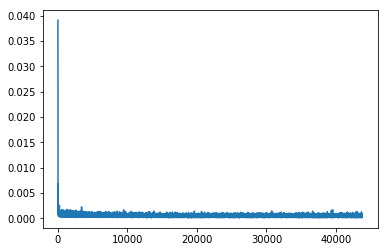

In [9]:
from matplotlib import pyplot as plt
plt.plot(loss_list)
plt.show()

In [8]:
# Guardamos el ultimo modelo
checkpoint_path_model = os.path.join('SINKP_NON_UCYUNIV_12_F', 'model.ckpt')
saver.save(sess,checkpoint_path_model , global_step = global_step)

'SINKP_NON_UCYUNIV_12_F/model.ckpt-43800'

# Restauramos los modelos

In [10]:
#Ultimo Modelo
path_model = 'SINKP_NON_UCYUNIV_12_F/model.ckpt-43800'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data_prueba, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

W0105 14:56:18.089180 139949982123776 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
  2%|1         | 9/502 [00:00<00:05, 83.88it/s]

Evaluating


100%|##########| 502/502 [00:05<00:00, 89.88it/s]


{'ade': 0.6475193, 'fde': 1.404657}


In [12]:
#Modelo12
path_model = 'SINKP_NON_UCYUNIV_12/model.ckpt-43800'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data_prueba, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

  1%|          | 5/502 [00:00<00:10, 45.41it/s]

Evaluating


100%|##########| 502/502 [00:06<00:00, 81.18it/s]

{'ade': 0.6475176, 'fde': 1.4046524}


In [13]:
# Mejor Modelo
path_model = 'SINKP_NON_UCYUNIV-BEST_12/model_best.ckpt-29400'
saver.restore(sess=sess, save_path=path_model)

test_data = batches_data.Dataset(data_prueba, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

  1%|1         | 7/502 [00:00<00:08, 61.49it/s]

Evaluating


100%|##########| 502/502 [00:05<00:00, 85.36it/s]


{'ade': 0.64713806, 'fde': 1.402884}
